<strong>Aluno</strong>: Victor São Paulo Ruela



In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from timeit import default_timer as timer

from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, r2_score
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, StratifiedKFold

from tqdm import tqdm

import matplotlib.pyplot as plt
from pylab import cm

plt.style.use('ggplot')


# Estudo do MLP para bases de dados multivariáveis

Neste trabalho é feita a implementação do algoritmo MLP com treinamento via back-propagation, e sua avaliação para a aproximação da função seno com ruído de medição uniforme.


In [ ]:
def load_heart_disease():
    data = pd.read_csv('heart.dat', sep=' ', header=None)
    data.dropna(inplace=True)
    data_np = data.to_numpy()
    X, y = data_np[:,:-1], data_np[:,-1]
    X = MinMaxScaler().fit_transform(X)
    y = pd.Series(y).map({1:-1,2:1}).to_numpy()
    return X,y

def load_boston_housing():
    X_bo, y_bo = load_boston(return_X_y = True)
    X_bo = MinMaxScaler().fit_transform(X_bo)
    y_bo = MinMaxScaler().fit_transform(y_bo.reshape(-1,1))
    
    return X_bo, y_bo.reshape(-1,)

In [ ]:
X_bh, y_bh = load_boston_housing()
X_hd, y_hd = load_heart_disease()

## Boston Housing

In [ ]:
models = []
models.append(('identity', {'hidden_layer_sizes': (100,), 'activation': 'identity' }))
models.append(('logistic', {'hidden_layer_sizes': (100,), 'activation': 'logistic' }))
models.append(('tanh', {'hidden_layer_sizes': (100,), 'activation': 'tanh' }))
models.append(('relu', {'hidden_layer_sizes': (100,), 'activation': 'relu' }))

models.append(('5x1', {'hidden_layer_sizes': (5,), 'activation': 'relu' }))
models.append(('500x1', {'hidden_layer_sizes': (500,), 'activation': 'relu' }))
models.append(('5000x1', {'hidden_layer_sizes': (5000,), 'activation': 'relu' }))

models.append(('100x2', {'hidden_layer_sizes': (100,100), 'activation': 'relu' }))
models.append(('100x3', {'hidden_layer_sizes': (100,100,100), 'activation': 'relu' }))
models.append(('100x4', {'hidden_layer_sizes': (100,100,100,100), 'activation': 'relu' }))

In [ ]:
def run_cross_validation(X, y):
    results = []
    kfold = KFold(10)
    for name, model_params in tqdm(models):
        mlp = MLPRegressor(hidden_layer_sizes=model_params['hidden_layer_sizes'], activation=model_params['activation'])
        fold = 1
        for train_index, test_index in tqdm(kfold.split(X, y)):
            # create the T and k dataset
            X_t, X_k = X[train_index, :], X[test_index, :]
            y_t, y_k = y[train_index], y[test_index]
            
            start = timer()
            mlp.fit(X_t, y_t)
            y_hat = mlp.predict(X_k)
            end = timer()
            elapsed = end - start

            mse = mean_squared_error(y_k, y_hat)
            r2 = r2_score(y_k, y_hat)

            results.append((name, fold, mse, r2, elapsed))
            fold = fold + 1
    return results
            

In [ ]:
results_bh = run_cross_validation(X_bh, y_bh)

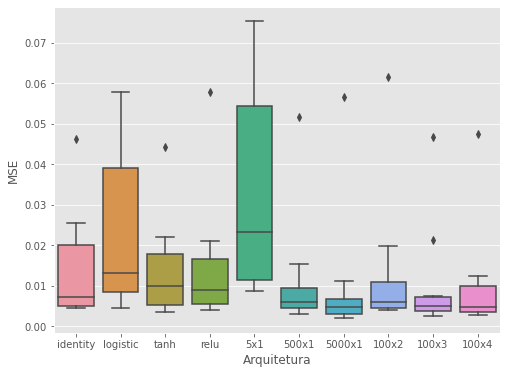

In [35]:
score_data = pd.DataFrame(results_bh, columns=['Arquitetura', 'fold', 'MSE', 'R2', 'Tempo [s]'])
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=score_data, x='Arquitetura', y='MSE', ax=ax)
fig.show()

# fig, ax = plt.subplots(figsize=(8, 6))
# sns.boxplot(data=score_data, x='Arquitetura', y='R2', ax=ax)
# fig.show()


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=score_data, x='Arquitetura', y='Tempo [s]', ax=ax)
fig.show()

A partir dos resultados acima, podemos observar que o algoritmo back-propagation é bastante sensível à inicialização dos pesos e sequência dos padrões apresentadas à rede. Observou-se também que o aumento exagerado do número épocas de treinamento levava o algoritmo a não convergir dependendo da escolha de ponto inicial. Isso pode ser observado para a aproximação #1, para a qual o algoritmo sofreu um aumento abrupto do MSE com 4000 épocas de treinamento. Observe também que ocorrem alguns picos desse valor para outras aproximações, embora elas consigam atingir a convergência. Estas observações comprovam a característica não-convexa deste modelo de rede neural, uma vez que o back-propagation é uma abordagem baseada em gradientes. Isso sugere o uso de técnicas de otimização mais robustas para lidar com esse problema.

Vale a pena ressaltar que foi necessário um ajuste fino da quantidade máxima de épocas de treinamento e taxa de aprendizado. Valores baixos podem resultar em convergência prematura, conforme foi observado durante testes iniciais. Além disso, observa-se um pouco de underfitting para algumas das aproximações obtidas, conforme visto pelos gráficos. Isso sugere que para a escolha de pesos iniciais, o algoritmo back-propagation ficou preso em algum mínimo local. Isso fica claro para a função #4, uma vez a rede não consegue evoluir após cerca de 1000 épocas. As demais curvas foram capazes de aproximar com precisão a função geradora, mesmo utilizando somente 3 neurônios na camada escondida.

## Heart Disease

In [36]:
def run_cross_validation_classification(X, y):
    results = []
    kfold = StratifiedKFold(10)
    for name, model_params in tqdm(models):
        mlp = MLPClassifier(hidden_layer_sizes=model_params['hidden_layer_sizes'], activation=model_params['activation'])
        fold = 1
        for train_index, test_index in tqdm(kfold.split(X, y)):
            # create the T and k dataset
            X_t, X_k = X[train_index, :], X[test_index, :]
            y_t, y_k = y[train_index], y[test_index]
            
            start = timer()
            mlp.fit(X_t, y_t)
            y_hat = mlp.predict(X_k)
            end = timer()
            elapsed = end - start

            acc = accuracy_score(y_k, y_hat)
            auc = roc_auc_score(y_k, y_hat)

            results.append((name, fold, acc, auc, elapsed))
            fold = fold + 1
    return results

In [37]:
results_hd = run_cross_validation_classification(X_hd, y_hd)

 iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(

9it [00:04,  2.06it/s]/home/victor/miniconda3/envs/dev-rna/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(

10it [00:04,  2.10it/s]
 30%|███       | 3/10 [00:12<00:29,  4.28s/it]
0it [00:00, ?it/s]/home/victor/miniconda3/envs/dev-rna/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(

1it [00:00,  2.52it/s]/home/victor/miniconda3/envs/dev-rna/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(

2it [00:00,  2.

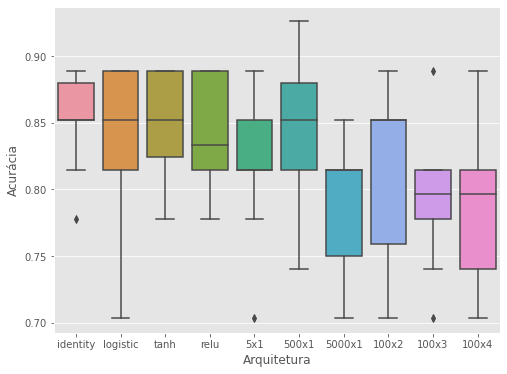

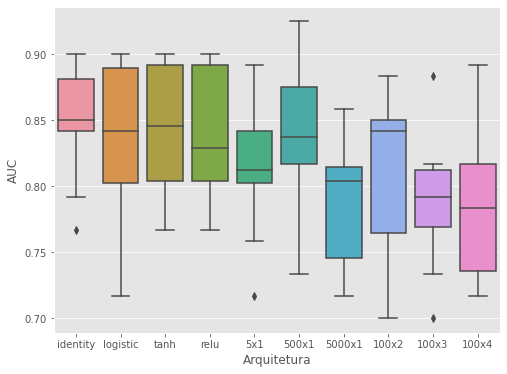

In [39]:
score_data = pd.DataFrame(results_hd, columns=['Arquitetura', 'fold', 'Acurácia', 'AUC', 'Tempo [s]'])
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=score_data, x='Arquitetura', y='Acurácia', ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=score_data, x='Arquitetura', y='AUC', ax=ax)
fig.show()